In [ ]:
! pip install transformers plotly datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.6 MB/s eta 0:00:00


In [1]:
! rm -rf space-model
! rm -rf nano-BERT
! git clone https://github.com/StepanTita/space-model.git
! git clone https://github.com/StepanTita/nano-BERT.git

Cloning into 'space-model'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 50 (delta 17), reused 39 (delta 10), pack-reused 0
Unpacking objects: 100% (50/50), 27.83 MiB | 4.31 MiB/s, done.
Cloning into 'nano-BERT'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 56 (delta 25), reused 30 (delta 8), pack-reused 0
Unpacking objects: 100% (56/56), 39.04 MiB | 4.40 MiB/s, done.


In [1]:
import sys

sys.path.append('space-model')

In [79]:
import math
import json
from collections import Counter
import random
import os

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

from datasets import load_dataset, Dataset, DatasetDict

from space_model.model import *
from space_model.loss import *

In [3]:
SEED = 42

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=SEED)

In [5]:
def on_gpu(f):
    def wrapper(*args):
        if torch.cuda.is_available():
            return f(*args)
        else:
            print('cuda unavailable')
    return wrapper

In [6]:
if torch.cuda.is_available():
    ! pip install pynvml
    from pynvml import *
    from numba import cuda

@on_gpu
def print_gpu_utilization(dev_id):
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(dev_id)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    except Exception as e:
        print(e)

@on_gpu
def free_gpu_cache(dev_id=0):
    print("Initial GPU Usage")
    print_gpu_utilization(dev_id)

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization(dev_id)

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [7]:
device_id = 1

In [8]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [9]:
torch.cuda.set_device(device)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [10]:
MODEL_NAME = 'bert-base-cased'
MODELS_PATH = 'models'
DATASET_NAME = 'hate-xplain'

NUM_EPOCHS = 5
BATCH_SIZE = 256
MAX_SEQ_LEN = 256
LEARNING_RATE = 2e-4
MAX_GRAD_NORM = 1000

NUM_LABELS = 3

In [11]:
data = None
with open('space-model/data/hate_dataset.json') as f:
    data = json.loads(f.read())

In [12]:
ids_split = None
with open('space-model/data/hate_post_id_divisions.json') as f:
    ids_split = json.loads(f.read())

In [13]:
def get_label(annotators):
    return Counter([anno['label'] for anno in annotators]).most_common(1)[0][0]

def encode_label(label):
    if label == 'hatespeech':
        return 0
    elif label == 'normal':
        return 1
    elif label == 'offensive':
        return 2
    raise Exception(f'Unknown Label: {label}!')

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [15]:
dataset = DatasetDict({
    'train': Dataset.from_list([{
        'text': ' '.join(data[post_id]['post_tokens']),
        'label': encode_label(get_label(data[post_id]['annotators']))
    } for post_id in tqdm(data, desc='Train') if post_id in ids_split['train']]),
    'test': Dataset.from_list([{
        'text': ' '.join(data[post_id]['post_tokens']),
        'label': encode_label(get_label(data[post_id]['annotators']))
    } for post_id in tqdm(data, desc='Test') if post_id in ids_split['test']]),
    'val': Dataset.from_list([{
        'text': ' '.join(data[post_id]['post_tokens']),
        'label': encode_label(get_label(data[post_id]['annotators']))
    } for post_id in tqdm(data, desc='Val') if post_id in ids_split['val']])
})
dataset

Val: 100%|██████████| 20148/20148 [00:00<00:00, 66966.02it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 15383
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1924
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1922
    })
})

In [16]:
tokenized_dataset = dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
tokenized_dataset.set_format('torch', device=device)
tokenized_dataset

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15383
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1924
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1922
    })
})

In [17]:
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device)
base_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
for p in base_model.bert.parameters():
    p.requires_grad = False
# for p in base_model.pre_classifier.parameters():
#     p.requires_grad = True

In [18]:
count_parameters(base_model)

2307

In [18]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def train(f):
    def wrapper(model, *args, **kwargs):
        model.train()
        return f(model, *args, **kwargs)
    return wrapper

In [19]:
@train
def train_epoch(model, train_dataloader, optimizer):
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for step, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        targets = batch['label'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets) # (B, Seq_Len, 2)

        loss, logits = outputs.loss, outputs.logits

        probs = F.softmax(logits, dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in targets.cpu()]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss, train_preds, train_labels

@eval
def eval_epoch(model, val_dataloader):
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['label'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)

            loss, logits = outputs.loss, outputs.logits

            probs = F.softmax(logits, dim=-1).cpu()
            pred = torch.argmax(probs, dim=-1) # (B)
            val_preds += pred.detach().tolist()
            val_labels += [l.item() for l in targets.cpu()]

            val_loss += loss.item()
    return val_loss, val_preds, val_labels

In [20]:
def training(model, train_data, val_data, config):
    model = model.to(device)

    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])

    print(f'Train steps: {num_train_steps}')

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=config['val_batch_size'])

    history = {
        'train_losses': [],
        'val_losses': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
    }

    for epoch_num in range(config['epochs']):
        print(f'Epoch: {epoch_num + 1}')

        # train stage
        train_loss, train_preds, train_labels = train_epoch(model, train_dataloader, optimizer)

        # eval stage
        val_loss, val_preds, val_labels = eval_epoch(model, val_dataloader)

        # metrics
        train_acc = accuracy_score(train_labels, train_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        train_precision = precision_score(train_labels, train_preds, average='weighted')
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')

        history['train_losses'].append(train_loss / len(train_dataloader))
        history['val_losses'].append(val_loss / len(val_dataloader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)

        print()
        print(f'Train loss: {train_loss / len(train_dataloader)} | Val loss: {val_loss / len(val_dataloader)}')
        print(f'Train acc: {train_acc} | Val acc: {val_acc}')
        print(f'Train f1: {train_f1} | Val f1: {val_f1}')
        print(f'Train precision: {train_precision} | Val precision: {val_precision}')
        print(f'Train recall: {train_recall} | Val recall: {val_recall}')

    free_gpu_cache(device_id)
    return history

In [ ]:
ids = tokenized_dataset['test'][0]['input_ids'].unsqueeze(0)
mask = tokenized_dataset['test'][0]['attention_mask'].unsqueeze(0)
targets = tokenized_dataset['test'][0]['label'].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

out = base_model(ids, mask, labels=targets)
out.loss

In [21]:
config = {
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'val_batch_size': BATCH_SIZE,
    'gradient_accumulation_steps': 1,
    'fp16': False,
    'lr': LEARNING_RATE,
    'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
}

In [29]:
history = training(base_model, tokenized_dataset['train'], tokenized_dataset['val'], config)

Train steps: 300
Epoch: 1


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 1.0859938527716966 | Val loss: 1.0774683356285095
Train acc: 0.4068127153351102 | Val acc: 0.40634755463059313
Train f1: 0.28219010659546784 | Val f1: 0.19262547786410159
Train precision: 0.3731204561034624 | Val precision: 0.16511833515426286
Train recall: 0.4068127153351102 | Val recall: 0.40634755463059313
Epoch: 2


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 1.0808225049347173 | Val loss: 1.07648466527462
Train acc: 0.415523629981148 | Val acc: 0.40634755463059313
Train f1: 0.30467322146161857 | Val f1: 0.19262547786410159
Train precision: 0.3905273357350209 | Val precision: 0.16511833515426286
Train recall: 0.415523629981148 | Val recall: 0.40634755463059313
Epoch: 3


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 1.074074776446233 | Val loss: 1.0676274374127388
Train acc: 0.42195930572710133 | Val acc: 0.46618106139438087
Train f1: 0.31145715131757434 | Val f1: 0.33570477302728824
Train precision: 0.39348825460323156 | Val precision: 0.34146402048119473
Train recall: 0.42195930572710133 | Val recall: 0.46618106139438087
Epoch: 4


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train loss: 1.0707065492379861 | Val loss: 1.0607654601335526
Train acc: 0.42930507703308846 | Val acc: 0.45733610822060355
Train f1: 0.32710006299078515 | Val f1: 0.34666677867973034
Train precision: 0.40542611163007025 | Val precision: 0.45137453914801656
Train recall: 0.42930507703308846 | Val recall: 0.45733610822060355
Epoch: 5


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Train loss: 1.0646757766848705 | Val loss: 1.0571686178445816
Train acc: 0.4349606708704414 | Val acc: 0.4505723204994797
Train f1: 0.34065737459072176 | Val f1: 0.3237076754842397
Train precision: 0.4102659328455326 | Val precision: 0.4473645989801378
Train recall: 0.4349606708704414 | Val recall: 0.4505723204994797
Initial GPU Usage
RM has detected an NVML/RM version mismatch.
GPU Usage after emptying the cache
RM has detected an NVML/RM version mismatch.


In [22]:
def plot_results(history, do_val=True):
    fig, ax = plt.subplots(figsize=(8, 8))

    x = list(range(0, len(history['train_losses'])))

    # loss

    ax.plot(x, history['train_losses'], label='train_loss')

    if do_val:
        ax.plot(x, history['val_losses'], label='val_loss')

    plt.title('Train / Validation Loss')
    plt.legend(loc='upper right')

    # accuracy

    if 'train_acc' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_acc'], label='train_acc')

        if do_val:
            ax.plot(x, history['val_acc'], label='val_acc')

    plt.title('Train / Validation Accuracy')
    plt.legend(loc='upper right')

    # f1-score

    if 'train_f1' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_f1'], label='train_f1')

        if do_val:
            ax.plot(x, history['val_f1'], label='val_f1')

        plt.title('Train / Validation F1')
        plt.legend(loc='upper right')

    # precision

    if 'train_precision' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_precision'], label='train_precision')

        if do_val:
            ax.plot(x, history['val_precision'], label='val_precision')

        plt.title('Train / Validation Precision')
        plt.legend(loc='upper right')

    # recall

    if 'train_recall' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_recall'], label='train_recall')

        if do_val:
            ax.plot(x, history['val_recall'], label='val_recall')

        plt.title('Train / Validation Recall')
        plt.legend(loc='upper right')

    fig.show()

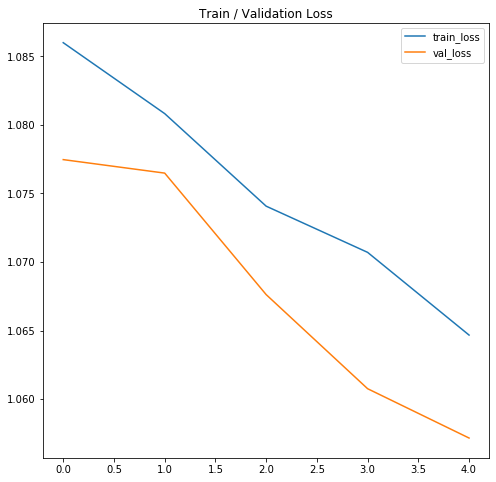

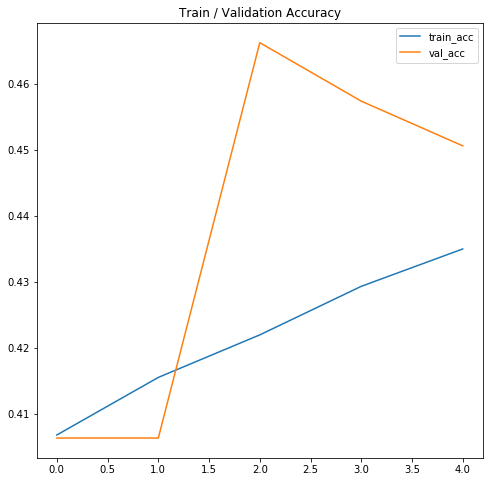

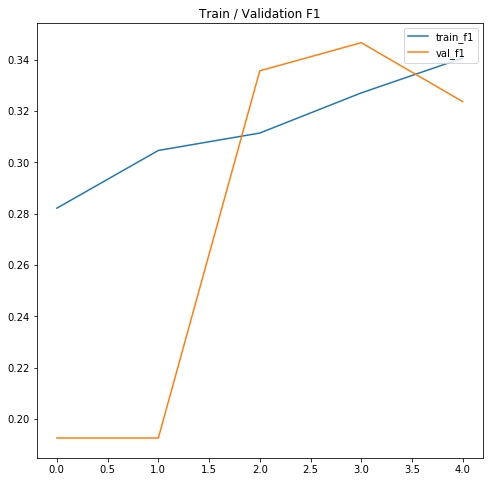

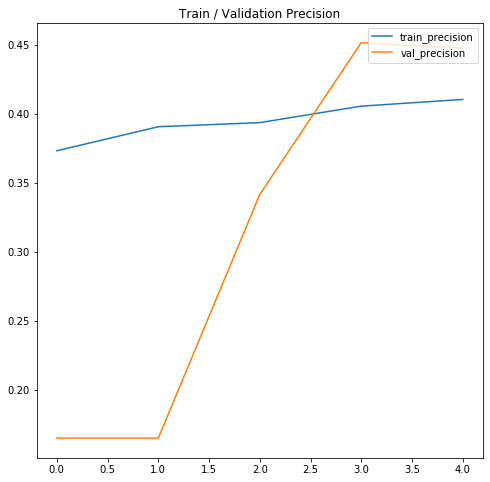

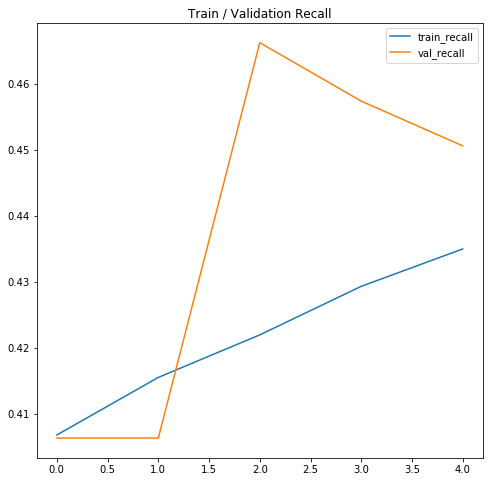

In [31]:
plot_results(history)

In [32]:
torch.save(base_model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}_{MODEL_NAME}_{NUM_EPOCHS}.bin')

In [28]:
val_dataset = tokenized_dataset['test']

In [29]:
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'])

In [ ]:
val_loss, val_preds, val_labels = eval_epoch(base_model, val_dataloader)

In [36]:
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds, average='weighted')
val_recall = recall_score(val_labels, val_preds, average='weighted')

In [37]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 1.0584700852632523
Val acc: 0.44854469854469853
Val f1: 0.33141168308944097
Val precision: 0.4471373214309317
Val recall: 0.44854469854469853


## Space Model

In [23]:
base_model = AutoModel.from_pretrained(MODEL_NAME)
base_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [24]:
space_model = SpaceModelForSequenceClassification(base_model, n_embed=768, n_latent=3, n_concept_spaces=3, l1=0, l2=0).to(device)
space_model

SpaceModelForSequenceClassification(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [25]:
count_parameters(space_model)

6942

In [30]:
ids = val_dataset[0]['input_ids'].unsqueeze(0)
mask = val_dataset[0]['attention_mask'].unsqueeze(0)
targets = val_dataset[0]['label'].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

base_embed = space_model.base_model(ids, mask).last_hidden_state

concept_spaces = space_model.space_model(base_embed).concept_spaces

In [31]:
print(f'Inter-space loss: {space_model.l1 * inter_space_loss(concept_spaces) * BATCH_SIZE}')

Inter-space loss: 0.0


In [32]:
print(f'Intra-space loss: {space_model.l2 * intra_space_loss(concept_spaces) * BATCH_SIZE}')

Intra-space loss: 0.0


In [33]:
space_history = training(space_model, tokenized_dataset['train'], tokenized_dataset['val'], config)

Train steps: 300
Epoch: 1


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Train loss: 1.0890190777231434 | Val loss: 1.0684728771448135
Train acc: 0.3744393161281935 | Val acc: 0.41571279916753384
Train f1: 0.2917881978427214 | Val f1: 0.2230822197081079
Train precision: 0.44594834570320857 | Val precision: 0.4516983578380737
Train recall: 0.3744393161281935 | Val recall: 0.41571279916753384
Epoch: 2


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train loss: 1.0537254614908187 | Val loss: 1.044873833656311
Train acc: 0.45335760254826757 | Val acc: 0.4921956295525494
Train f1: 0.30543728805643805 | Val f1: 0.37753272025536555
Train precision: 0.4876584137793953 | Val precision: 0.47921348021625054
Train recall: 0.45335760254826757 | Val recall: 0.4921956295525494
Epoch: 3


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train loss: 1.033879035809001 | Val loss: 1.026186354458332
Train acc: 0.5058831177273614 | Val acc: 0.5109261186264308
Train f1: 0.3953896560526906 | Val f1: 0.40310102400323755
Train precision: 0.5261402313435014 | Val precision: 0.5117924295390645
Train recall: 0.5058831177273614 | Val recall: 0.5109261186264308
Epoch: 4


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train loss: 1.0176084276105537 | Val loss: 1.0121304914355278
Train acc: 0.5179093804849509 | Val acc: 0.5197710718002081
Train f1: 0.4115621948997285 | Val f1: 0.4222921002340396
Train precision: 0.5349991386590641 | Val precision: 0.517851802380072
Train recall: 0.5179093804849509 | Val recall: 0.5197710718002081
Epoch: 5


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Train loss: 1.0035840566041039 | Val loss: 1.0017273873090744
Train acc: 0.5247350971852044 | Val acc: 0.5228928199791884
Train f1: 0.42490206147616744 | Val f1: 0.4245649153669757
Train precision: 0.5327968522287869 | Val precision: 0.5241705567093996
Train recall: 0.5247350971852044 | Val recall: 0.5228928199791884
Initial GPU Usage
RM has detected an NVML/RM version mismatch.
GPU Usage after emptying the cache
RM has detected an NVML/RM version mismatch.


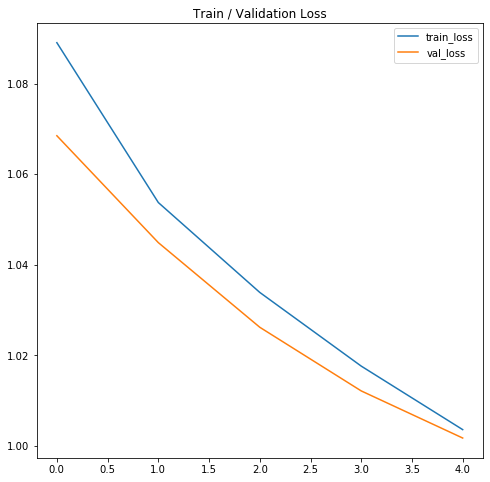

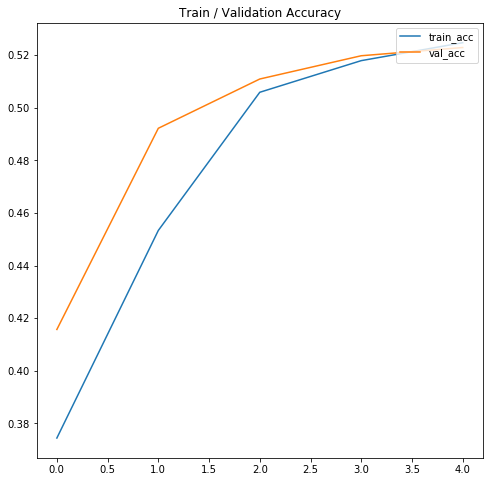

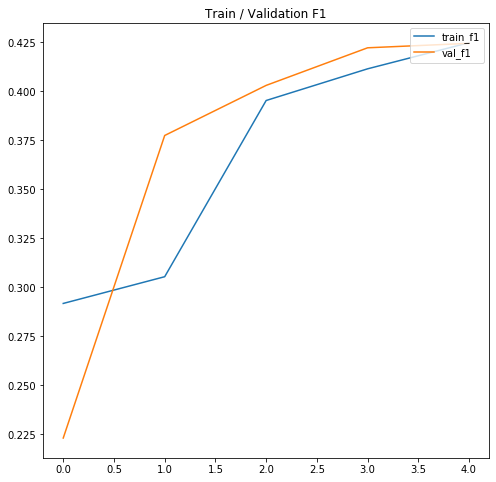

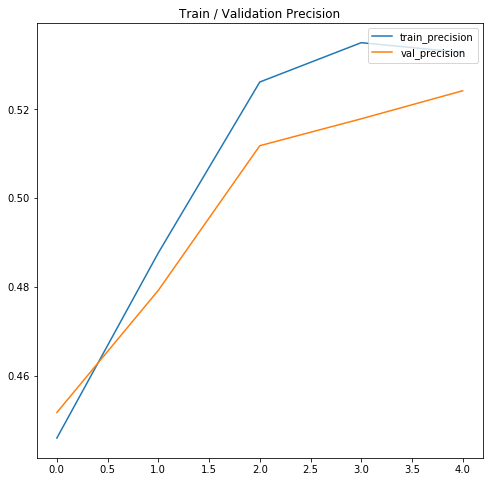

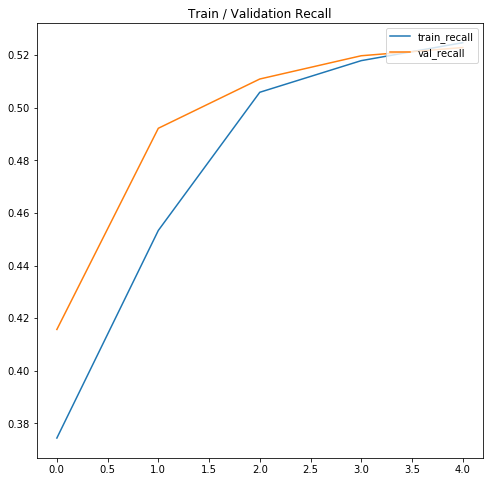

In [34]:
plot_results(space_history)

In [35]:
val_loss, val_preds, val_labels = eval_epoch(space_model, val_dataloader)

100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


In [36]:
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds, average='weighted')
val_recall = recall_score(val_labels, val_preds, average='weighted')

In [37]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.9969483464956284
Val acc: 0.5296257796257796
Val f1: 0.43046442298250837
Val precision: 0.5431336610534568
Val recall: 0.5296257796257796


In [38]:
torch.save(space_model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}_space-{MODEL_NAME}_{NUM_EPOCHS}.bin')

### Interpretation

In [40]:
test_dataset = tokenized_dataset['test']

In [41]:
# examples with less than 16 words are easier to visualize, so focus on them
examples_ids = []
for i, v in enumerate(list(test_dataset['input_ids'])):
    s = [t for t in v.cpu() if t != tokenizer.pad_token_id]
    if len(s) <= 16:
        examples_ids.append(i)
print(examples_ids)

[4, 7, 11, 15, 16, 19, 28, 29, 31, 34, 46, 52, 56, 57, 59, 66, 67, 69, 71, 72, 75, 83, 90, 93, 101, 103, 113, 117, 118, 122, 124, 126, 135, 143, 148, 149, 150, 153, 160, 162, 164, 170, 179, 183, 200, 206, 216, 223, 224, 225, 227, 229, 239, 242, 245, 247, 251, 253, 256, 259, 260, 265, 267, 274, 291, 293, 301, 303, 306, 309, 310, 316, 317, 319, 320, 324, 329, 330, 331, 335, 338, 340, 344, 352, 353, 354, 357, 360, 363, 366, 367, 370, 374, 376, 377, 380, 385, 390, 392, 395, 407, 410, 417, 422, 427, 432, 437, 440, 441, 442, 443, 444, 451, 452, 454, 455, 472, 476, 479, 480, 484, 487, 488, 493, 494, 495, 498, 499, 500, 501, 512, 513, 515, 518, 519, 524, 525, 528, 545, 552, 561, 573, 577, 584, 590, 592, 598, 599, 600, 602, 604, 608, 611, 619, 623, 626, 630, 631, 634, 635, 636, 638, 640, 647, 656, 673, 677, 680, 683, 687, 691, 695, 699, 706, 707, 717, 725, 726, 727, 729, 731, 734, 738, 739, 741, 743, 750, 757, 773, 774, 777, 782, 788, 791, 792, 793, 796, 798, 803, 804, 807, 809, 814, 820, 821, 

## Biases vectors visualized

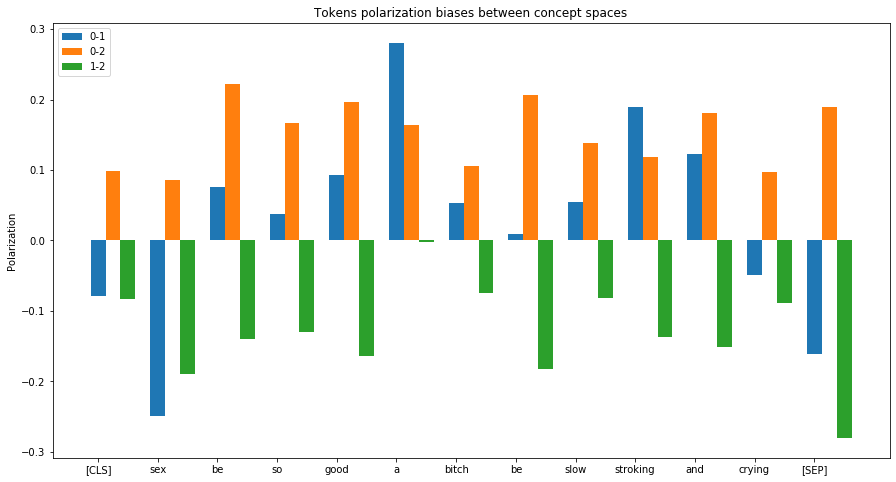

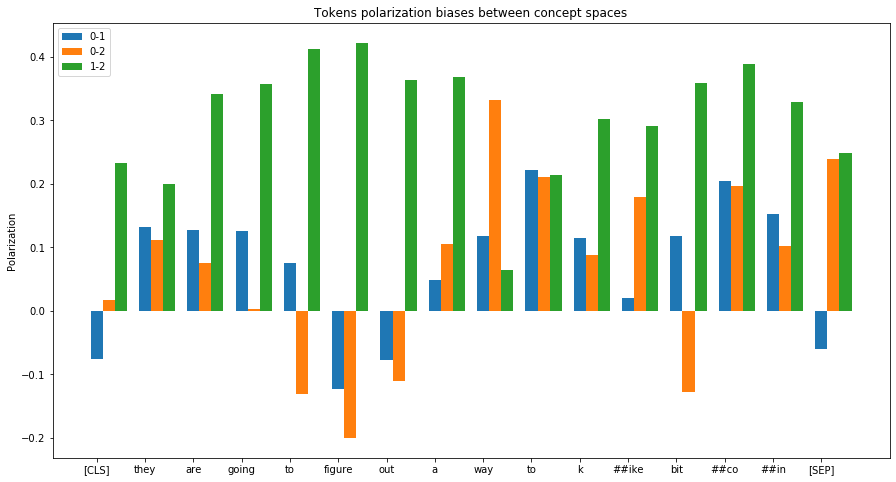

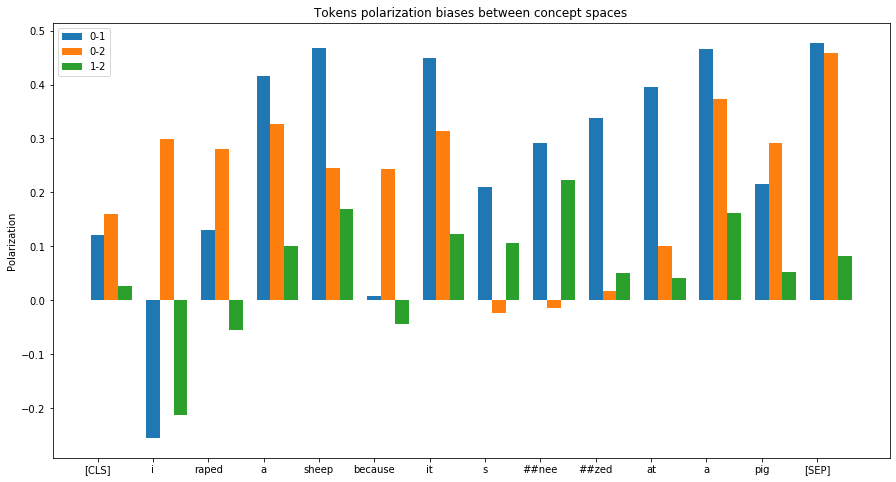

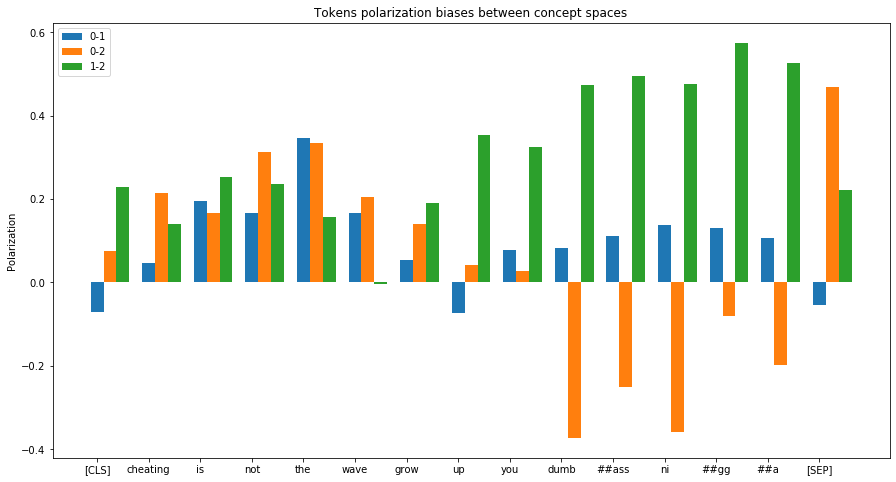

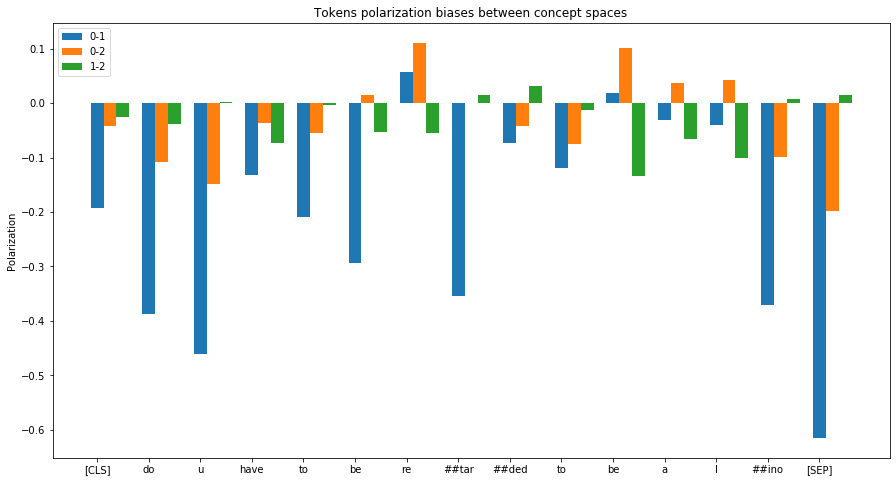

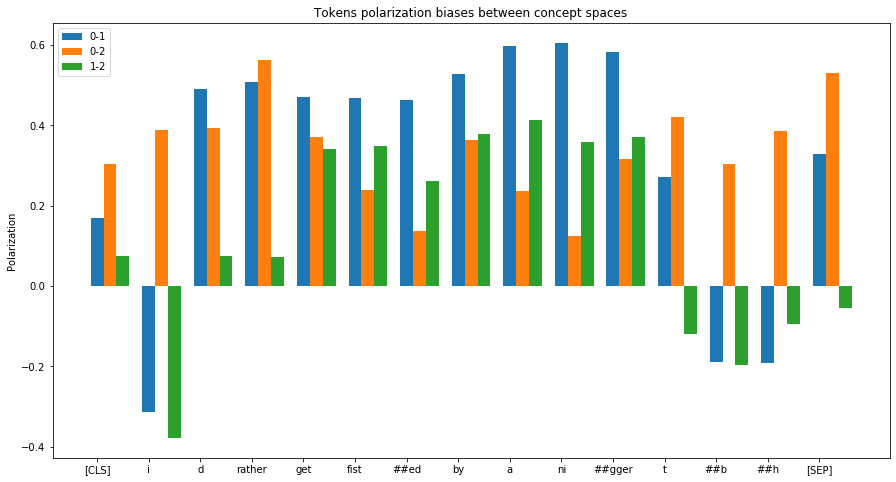

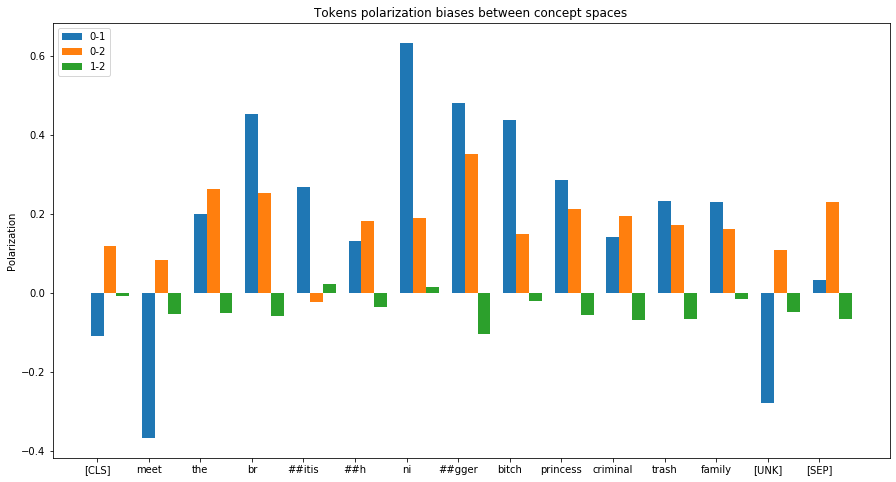

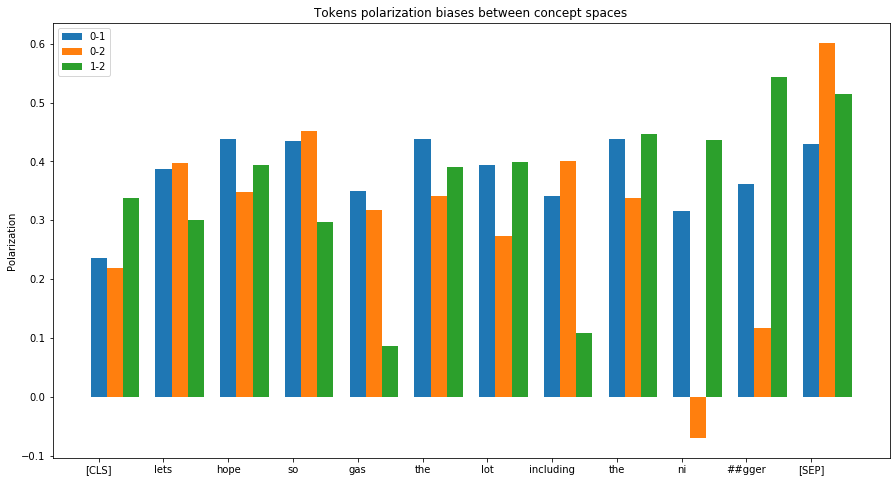

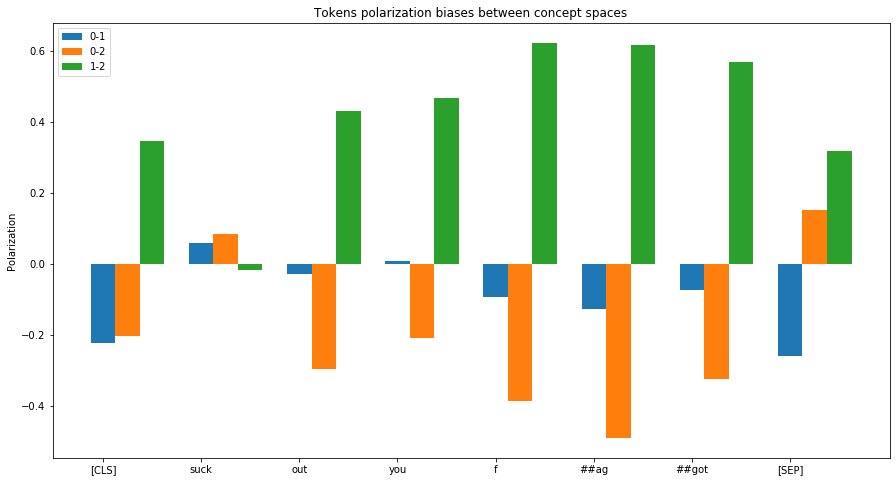

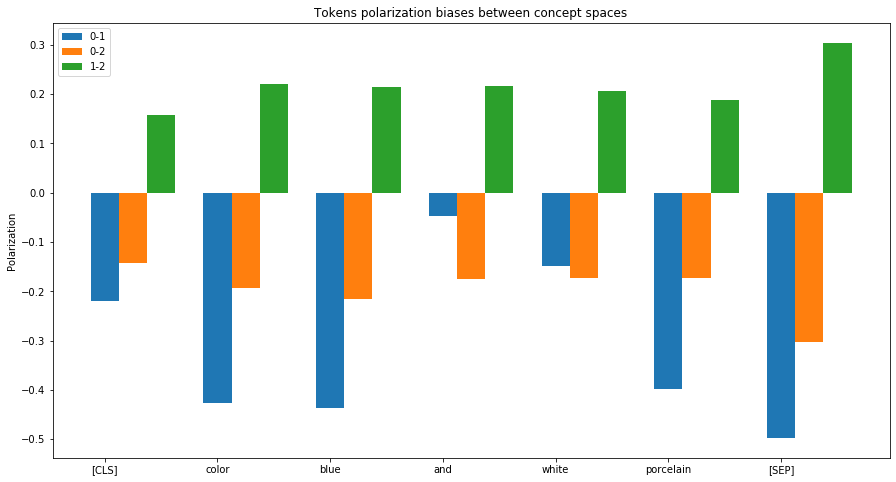

In [117]:
for sample_index in examples_ids[:10]:
    ids, mask = test_dataset[sample_index]['input_ids'].unsqueeze(0), test_dataset[sample_index]['attention_mask'].unsqueeze(0)
    
    concept_spaces = space_model.get_concept_spaces(ids, mask)
    
    biases = dict()

    for i in range(len(concept_spaces)):
        for j in range(i + 1, len(concept_spaces)):
            biases[f'{i}-{j}'] = torch.diagonal(
                F.tanh(concept_spaces[i][:, :mask.sum(), :mask.sum()] @ concept_spaces[j][:, :mask.sum(), :mask.sum()].permute(0, -1, -2)), 0
            ).detach().cpu()[:, 0].tolist()
    
    tokens = [tokenizer.decode(t) for t in ids[0] if t != tokenizer.pad_token_id]

    x = np.arange(len(tokens))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(15, 8))

    for concept_pair, measurement in biases.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=concept_pair)
        multiplier += 1

    ax.set_ylabel('Polarization')
    ax.set_title('Tokens polarization biases between concept spaces')
    ax.set_xticks(x)
    ax.set_xticklabels(tokens)
    ax.legend(loc='upper left')

    plt.show()

In [42]:
scatters = []
colors = ['blue', 'red']
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataset[sample_index]
    tokens = [tokenizer.decode(t) for t in test_tokenized_batch['input_ids'] if t != tokenizer.pad_token_id]
    seq_len = len(tokens)

    input_ids = test_tokenized_batch['input_ids'].to(device).unsqueeze(0)
    attention_mask = test_tokenized_batch['attention_mask'].to(device).unsqueeze(0)

    base_embed = space_model.base_model(input_ids, attention_mask).last_hidden_state

    concept_spaces = space_model.space_model(base_embed).concept_spaces

    print()

    for c, embed in enumerate(concept_spaces):
        x, y, z = embed[0, :seq_len, 0].detach().cpu().numpy(), embed[0, :seq_len, 1].detach().cpu().numpy(), embed[0, :seq_len, 2].detach().cpu().numpy()

        scatters.append(go.Scatter3d(
            x=x, y=y, z=z, mode='markers+text',
            name=f'Example: {sample_index} ({c})',
            text=tokens,
            marker=dict(color=colors[c]),
            # hovertext=[]
        ))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-42-f79da2a82f3f>:25 in <module>                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

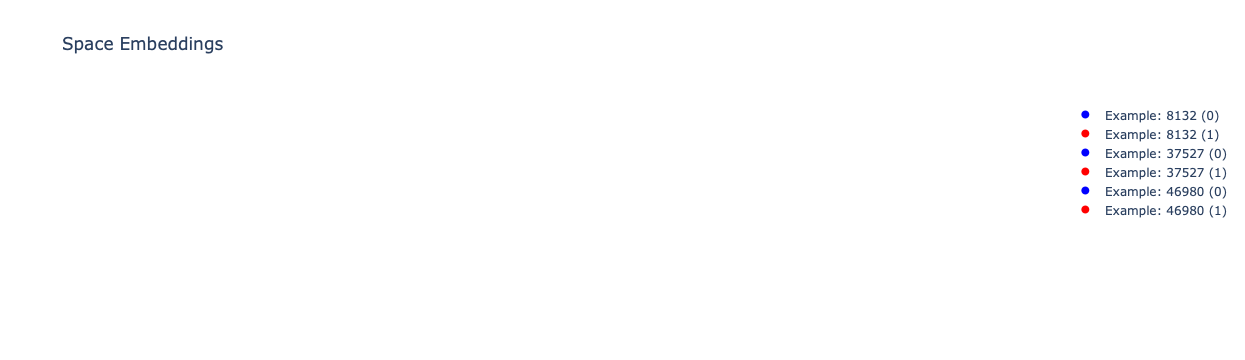

In [196]:
fig = go.Figure(
    data=scatters,
    layout=go.Layout(
        title=go.layout.Title(text='Space Embeddings')
    ))
fig.show()

In [197]:
fig.write_html(f'plots/{DATASET_NAME}_space-{MODEL_NAME}_{NUM_EPOCHS}.html')

In [192]:
# space_bert = SpaceBertForSequenceClassification(bert, n_embed=768, n_latent=3, n_concept_spaces=2, l1=0, l2=0).to(device)
# space_bert.load_state_dict(torch.load(f'{MODELS_PATH}/ce_loss_2_epochs.bin'))
# space_bert